In [517]:
from statsmodels.iolib.summary2 import summary_col
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup

In [518]:
url = 'https://github.com/SofiyaLyn/Thesis/raw/main/cleaned_data.csv'
cleaned_data = pd.read_csv(url)
cleaned_data.head()

,Year,Country,"Proceeds_Amount_+_Over_Sold_This_Market_(USD,_mln)",IPO_market_share,IPOs_Number_of_Issues,P/E_Ratio,E/P_ratio,Stock_Market_Index,Interest_rate_up_to_1_mln,Interest_rate_over_€1M,...,Population_Growth_(%),Real_Private_Consumption_Growth_(%),Real_Government_Consumption_Growth_(%),Real_Gross_Fixed_Investment_Growth_(%),"Real_Gross_Fixed_Investment,_LCU_(BGNB)",Industrial_Production_Growth_(%),Unnamed: 37,"Nominal_GDP_(EUR,B)","Real_GDP_(EUR,B)",GDP_Per_Capita_(EUR)
0,2009,Hungary,0,0,1,15,0.07,21227,0,0,...,0,-5,1,-9,6.92,-17,NaN,94,89,9472.796705
1,2010,Hungary,179,64,4,12,0.08,21327,9,7,...,0,-1,1,-9,6.27,10,NaN,99,94,10052.830609
2,2011,Hungary,0,0,1,10,0.09,16974,9,7,...,0,0,0,-1,6.19,5,NaN,102,92,10315.512485
3,2012,Hungary,2,1,1,12,0.08,18173,10,8,...,0,-2,0,-2,6.00,-1,NaN,100,98,10159.640774
4,2013,Hungary,1,0,1,10,0.09,18564,8,7,...,0,0,5,9,6.59,1,NaN,102,97,10393.684700


In [519]:
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238 entries, 0 to 237
Data columns (total 23 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   Year                                                238 non-null    int64  
 1   Country                                             238 non-null    object 
 2   Proceeds_Amount_+_Over_Sold_This_Market_(USD,_mln)  238 non-null    int64  
 3   IPO_market_share                                    238 non-null    int64  
 4   IPOs_Number_of_Issues                               238 non-null    int64  
 5   P/E_Ratio                                           238 non-null    int64  
 6   E/P_ratio                                           238 non-null    object 
 7   Stock_Market_Index                                  238 non-null    int64  
 8   Interest_rate_up_to_1_mln                           238 non-null    int64  
 9  

In [520]:
cleaned_data.columns = (cleaned_data.columns.str.replace('(', '_')
                        .str.replace(')', '')
                        .str.replace('%', 'Percent')
                        .str.replace('$', 'Dollar')
                        .str.replace('€', 'Euro')
                        .str.replace(',', ''))

In [521]:
cleaned_data = cleaned_data[~cleaned_data['Country'].isin(['Georgia', 'Albania', 'Bulgaria'])]
cleaned_data['treated'] = cleaned_data['Country'].isin(["Hungary", "Poland", "Slovakia", "Czech Republic", "Slovenia", "Romania", "Estonia", "Latvia", "Lithuania"])
cleaned_data['treated'] = cleaned_data['treated'].astype(int)

cleaned_data['post_intervention'] = (cleaned_data['Year'] >= 2015).astype(int)
cleaned_data['treated_intervention'] = cleaned_data['treated'] * cleaned_data['post_intervention']

cleaned_data = cleaned_data.rename(columns={'E/P_ratio': 'Earnings_Price'})
print(cleaned_data.columns)

Index(['Year', 'Country', 'Proceeds_Amount_+_Over_Sold_This_Market__USD_mln',
       'IPO_market_share', 'IPOs_Number_of_Issues', 'P/E_Ratio',
       'Earnings_Price', 'Stock_Market_Index', 'Interest_rate_up_to_1_mln',
       'Interest_rate_over_Euro1M', 'Aver_interest_rate_to_nonfinance',
       'Real_GDP_Growth__Percent', 'Population__M',
       'Population_Growth__Percent',
       'Real_Private_Consumption_Growth__Percent',
       'Real_Government_Consumption_Growth__Percent',
       'Real_Gross_Fixed_Investment_Growth__Percent',
       'Real_Gross_Fixed_Investment_LCU__BGNB',
       'Industrial_Production_Growth__Percent', 'Unnamed: 37',
       'Nominal_GDP__EURB', 'Real_GDP__EURB', 'GDP_Per_Capita__EUR', 'treated',
       'post_intervention', 'treated_intervention'],
      dtype='object')


In [522]:
print(cleaned_data['Earnings_Price'].describe())

count      196
unique      27
top       0.08
freq        23
Name: Earnings_Price, dtype: object


## Dependent variable should be a numeric one, E/P ratio

In [523]:
cleaned_data['Earnings_Price'] = pd.to_numeric(cleaned_data['Earnings_Price'], errors='coerce')
cleaned_data['Earnings_Price'].fillna(cleaned_data['Earnings_Price'].mean(), inplace=True)

formula = 'Earnings_Price ~ treated + post_intervention + treated_intervention' 

model = smf.ols(formula, data=cleaned_data).fit() 

info_dict = {'R-squared' : lambda x: f"{x.rsquared:.2f}",
             'No. observations' : lambda x: f"{int(x.nobs):d}"}

summary_table = summary_col([model], stars=True, info_dict=info_dict)

soup = BeautifulSoup(summary_table.as_html(), 'html.parser')

table = soup.find('table')

table['style'] = 'border: 1px solid black'

for th in table.find_all('th'):
    th['style'] = 'text-align: center'

additional_text = soup.new_tag('div')
additional_text.string = 'Standard errors in parentheses.\n* p<.1, ** p<.05, ***p<.01'

with open('/Users/sonetalyn/Desktop/Thesis/Earnings Price Ratio.html', 'w') as f:
    f.write(str(soup))

# Print the summary table
print(summary_table)


                     Earnings_Price
-----------------------------------
Intercept            0.0813***     
                     (0.0097)      
treated              0.0033        
                     (0.0128)      
post_intervention    0.0176        
                     (0.0128)      
treated_intervention -0.0153       
                     (0.0169)      
R-squared            0.0121        
R-squared Adj.       -0.0033       
R-squared            0.01          
No. observations     196           
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


In [500]:
print(cleaned_data['Earnings_Price'])

0      0.07
1      0.08
2      0.09
3      0.08
4      0.09
       ... 
233    0.13
234    0.13
235    0.13
236    0.38
237    0.03
Name: Earnings_Price, Length: 196, dtype: float64


# Ploting Graph

In [524]:
grouped_data = cleaned_data.groupby(['Year', 'treated']).agg({'Earnings_Price': 'mean'}).reset_index()
sns.set(style="whitegrid")


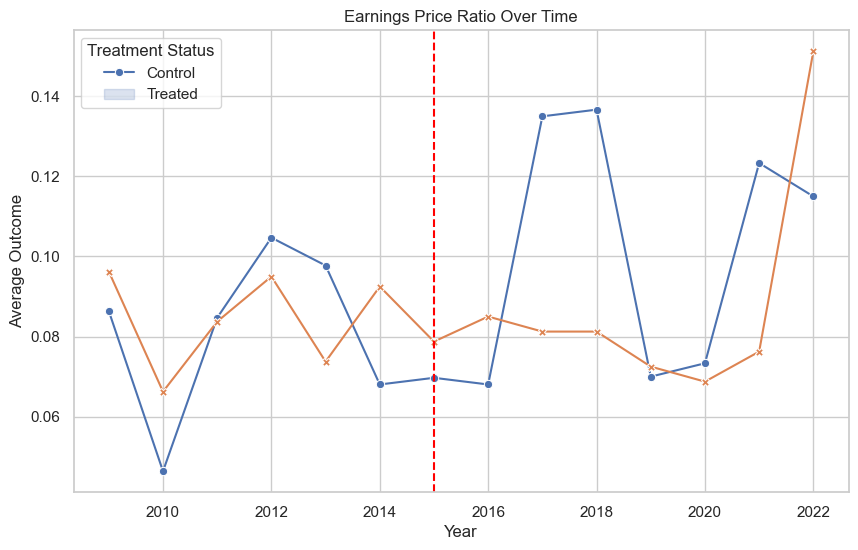

In [525]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=grouped_data, x='Year', y='Earnings_Price', hue='treated', style='treated', markers=True, dashes=False)

# Adding labels and title
plt.title('Earnings Price Ratio Over Time')
plt.xlabel('Year')
plt.ylabel('Average Outcome')
plt.axvline(x=2015, color='red', linestyle='--')
plt.legend(title='Treatment Status', labels=['Control', 'Treated'])
plt.savefig('/Users/sonetalyn/Desktop/Thesis/Earnings Price Ratio plot.png')
# Show the plot
plt.show()


## Just with controlled variables

In [526]:

cleaned_data['intercept'] = 1
formula = """Earnings_Price ~ treated + post_intervention + treated_intervention + Population__M + Real_GDP__EURB + GDP_Per_Capita__EUR + Real_Government_Consumption_Growth__Percent + Real_Gross_Fixed_Investment_Growth__Percent + Industrial_Production_Growth__Percent + intercept"""
model = smf.ols(formula, data=cleaned_data).fit()

info_dict = {'R-squared' : lambda x: f"{x.rsquared:.2f}",
             'No. observations' : lambda x: f"{int(x.nobs):d}"}

summary_table = summary_col([model], stars=True, info_dict=info_dict)

soup = BeautifulSoup(summary_table.as_html(), 'html.parser')

table = soup.find('table')

table['style'] = 'border: 1px solid black'

for th in table.find_all('th'):
    th['style'] = 'text-align: center'

additional_text = soup.new_tag('div')
additional_text.string = 'Standard errors in parentheses.\n* p<.1, ** p<.05, ***p<.01'

with open('/Users/sonetalyn/Desktop/Thesis/Controlled Earnings Price Ratio.html', 'w') as f:
    f.write(str(soup))

print(summary_table)


                                            Earnings_Price
----------------------------------------------------------
Intercept                                   0.0348***     
                                            (0.0072)      
treated                                     0.0003        
                                            (0.0133)      
post_intervention                           0.0181        
                                            (0.0134)      
treated_intervention                        -0.0157       
                                            (0.0173)      
Population__M                               0.0004        
                                            (0.0004)      
Real_GDP__EURB                              -0.0000       
                                            (0.0001)      
GDP_Per_Capita__EUR                         0.0000        
                                            (0.0000)      
Real_Government_Consumption_Growth__Percent -0.0019*   

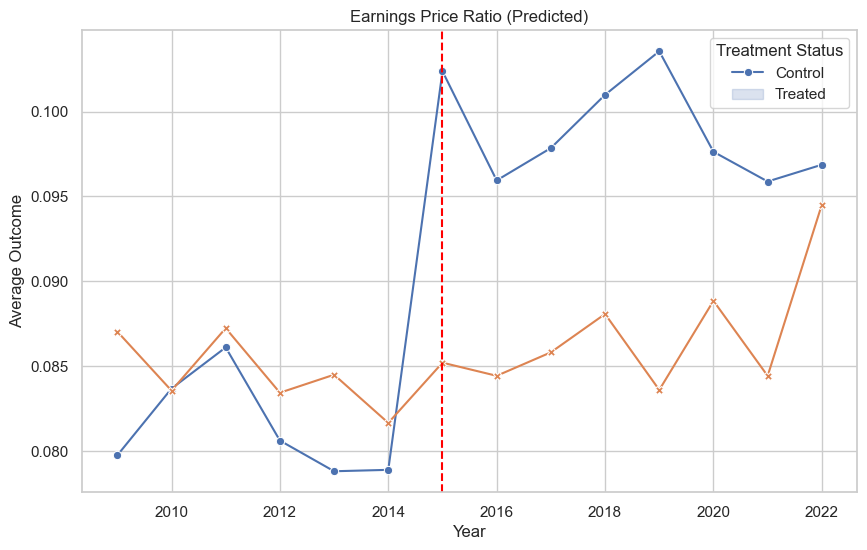

In [527]:
model = smf.ols(formula, data=cleaned_data).fit()

cleaned_data['predicted'] = model.predict(cleaned_data)

# Group the data by 'Year' and 'treated', and calculate the mean of 'predicted'
grouped_data = cleaned_data.groupby(['Year', 'treated'])['predicted'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(data=grouped_data, x='Year', y='predicted', hue='treated', style='treated', markers=True, dashes=False)

# Adding labels and title
plt.title('Earnings Price Ratio (Predicted)')
plt.xlabel('Year')
plt.ylabel('Average Outcome')
plt.legend(title='Treatment Status', labels=['Control', 'Treated'])
plt.axvline(x=2015, color='red', linestyle='--')

# Save the plot
plt.savefig('/Users/sonetalyn/Desktop/Thesis/Controlled Earnings Price Ratio.png')

# Show the plot
plt.show()

In [483]:
print(cleaned_data.isnull().sum())

Year                                                  0
Country                                               0
Proceeds_Amount_+_Over_Sold_This_Market__USD_mln      0
IPO_market_share                                      0
IPOs_Number_of_Issues                                 0
P/E_Ratio                                             0
Earnings_Price                                        0
Stock_Market_Index                                    0
Interest_rate_up_to_1_mln                             0
Interest_rate_over_Euro1M                             0
Aver_interest_rate_to_nonfinance                      0
Real_GDP_Growth__Percent                              0
Population__M                                         0
Population_Growth__Percent                            0
Real_Private_Consumption_Growth__Percent              0
Real_Government_Consumption_Growth__Percent           0
Real_Gross_Fixed_Investment_Growth__Percent           0
Industrial_Production_Growth__Percent           

## With Fixed Effects

In [528]:
from bs4 import BeautifulSoup
from statsmodels.iolib.summary2 import summary_col

formula = 'Earnings_Price ~ treated + post_intervention + treated_intervention + C(Year) + C(Country)'
model = smf.ols(formula, data=cleaned_data).fit()

info_dict = {'R-squared' : lambda x: f"{x.rsquared:.2f}",
             'No. observations' : lambda x: f"{int(x.nobs):d}"}

summary_table = summary_col([model], stars=True, info_dict=info_dict)

soup = BeautifulSoup(summary_table.as_html(), 'html.parser')

table = soup.find('table')

table['style'] = 'border: 1px solid black'

for th in table.find_all('th'):
    th['style'] = 'text-align: center'

additional_text = soup.new_tag('div')
additional_text.string = 'Standard errors in parentheses.\n* p<.1, ** p<.05, ***p<.01'

with open('/Users/sonetalyn/Desktop/Thesis/Earnings Price with Fixed Effects and Controls.html', 'w') as f:
    f.write(str(soup))

print(summary_table)


                              Earnings_Price
--------------------------------------------
Intercept                     0.0422**      
                              (0.0209)      
C(Year)[T.2010]               -0.0343*      
                              (0.0206)      
C(Year)[T.2011]               -0.0079       
                              (0.0206)      
C(Year)[T.2012]               0.0071        
                              (0.0206)      
C(Year)[T.2013]               -0.0080       
                              (0.0206)      
C(Year)[T.2014]               -0.0100       
                              (0.0206)      
C(Year)[T.2015]               -0.0162       
                              (0.0138)      
C(Year)[T.2016]               -0.0133       
                              (0.0138)      
C(Year)[T.2017]               0.0132        
                              (0.0138)      
C(Year)[T.2018]               0.0139        
                              (0.0138)      
C(Year)[T

# FE With Controlled Variables

In [529]:
from bs4 import BeautifulSoup
from statsmodels.iolib.summary2 import summary_col

formula = 'Earnings_Price ~ treated + post_intervention + treated_intervention + C(Year) + C(Country) + Real_GDP__EURB + GDP_Per_Capita__EUR + Population__M + Real_Private_Consumption_Growth__Percent + Real_Government_Consumption_Growth__Percent + Real_Gross_Fixed_Investment_Growth__Percent + Industrial_Production_Growth__Percent'
model = smf.ols(formula, data=cleaned_data).fit()

info_dict = {'R-squared' : lambda x: f"{x.rsquared:.2f}",
             'No. observations' : lambda x: f"{int(x.nobs):d}"}

summary_table = summary_col([model], stars=True, info_dict=info_dict)

soup = BeautifulSoup(summary_table.as_html(), 'html.parser')

table = soup.find('table')

table['style'] = 'border: 1px solid black'

for th in table.find_all('th'):
    th['style'] = 'text-align: center'

additional_text = soup.new_tag('div')
additional_text.string = 'Standard errors in parentheses.\n* p<.1, ** p<.05, ***p<.01'

with open('/Users/sonetalyn/Desktop/Thesis/Earnings Price with Fixed Effects and Controls.html', 'w') as f:
    f.write(str(soup))

print(summary_table)


                                            Earnings_Price
----------------------------------------------------------
Intercept                                   0.0401        
                                            (0.0288)      
C(Year)[T.2010]                             -0.0457*      
                                            (0.0259)      
C(Year)[T.2011]                             -0.0170       
                                            (0.0269)      
C(Year)[T.2012]                             0.0043        
                                            (0.0248)      
C(Year)[T.2013]                             -0.0106       
                                            (0.0250)      
C(Year)[T.2014]                             -0.0082       
                                            (0.0258)      
C(Year)[T.2015]                             -0.0167       
                                            (0.0152)      
C(Year)[T.2016]                             -0.0112    

## Combined table

In [530]:
from bs4 import BeautifulSoup
from statsmodels.iolib.summary2 import summary_col

formulas = [
    'Earnings_Price ~ treated + post_intervention + treated_intervention',
    'Earnings_Price ~ treated + post_intervention + treated_intervention + Real_GDP__EURB + GDP_Per_Capita__EUR + Population__M + Real_Private_Consumption_Growth__Percent + Real_Government_Consumption_Growth__Percent + Real_Gross_Fixed_Investment_Growth__Percent + Industrial_Production_Growth__Percent',
    'Earnings_Price ~ treated + post_intervention + treated_intervention + C(Year) + C(Country)',
    'Earnings_Price ~ treated + post_intervention + treated_intervention + C(Year) + C(Country) + Real_GDP__EURB + GDP_Per_Capita__EUR + Population__M + Real_Private_Consumption_Growth__Percent + Real_Government_Consumption_Growth__Percent + Real_Gross_Fixed_Investment_Growth__Percent + Industrial_Production_Growth__Percent'
]

models = [smf.ols(formula, data=cleaned_data).fit() for formula in formulas]

info_dict = {'R-squared' : lambda x: f"{x.rsquared:.2f}",
             'No. observations' : lambda x: f"{int(x.nobs):d}"}

summary_table = summary_col(models, stars=True, info_dict=info_dict)

soup = BeautifulSoup(summary_table.as_html(), 'html.parser')

table = soup.find('table')

table['style'] = 'border: 1px solid black'

for th in table.find_all('th'):
    th['style'] = 'text-align: center'

additional_text = soup.new_tag('div')
additional_text.string = 'Standard errors in parentheses.\n* p<.1, ** p<.05, ***p<.01'

with open('/Users/sonetalyn/Desktop/Thesis/Combined_EP_Summary.html', 'w') as f:
    f.write(str(soup))

print(summary_table)


                                            Earnings_Price I Earnings_Price II Earnings_Price III Earnings_Price IIII
---------------------------------------------------------------------------------------------------------------------
C(Country)[T.Czechia]                                                          0.0344*            0.0194             
                                                                               (0.0206)           (0.0657)           
C(Country)[T.Estonia]                                                          -0.0152            0.1096             
                                                                               (0.0138)           (0.0896)           
C(Country)[T.Hungary]                                                          0.0191             0.0051             
                                                                               (0.0138)           (0.0165)           
C(Country)[T.Latvia]                                   